<a href="https://colab.research.google.com/github/praveenprabharavindran/MachineLearning/blob/main/HyperparameterTuning/HyperParameter_Tuning_ANN_Handwritten_Digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Housekeeping before defining the model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Load the MNIST dataset and split into train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the pixel values
x_train = x_train / 255.0
x_test = x_test / 255.0

# Plot confusion matrix
def plot_confusion_matrix(true_labels, predicted_labels):
    matrix = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix, annot=True, fmt='d')
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# Plot model metric
def plot_metric(history, metric_type):
    if metric_type not in ('accuracy', 'loss'):
        print("Invalid metric type. Please use 'accuracy' or 'loss'.")
        return

    if metric_type == 'accuracy':
        train_metric = 'accuracy'
        test_metric = 'val_accuracy'
        y_label = 'Accuracy'
    else:
        train_metric = 'loss'
        test_metric = 'val_loss'
        y_label = 'Loss'

    # Plot the chosen metric
    plt.plot(history.history[train_metric], label='Train')
    plt.plot(history.history[test_metric], label='Test')
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()
    plt.title(metric_type.capitalize())
    plt.show()


Install Keras Tuner:

In [7]:
!pip install keras-tuner
from kerastuner.tuners import RandomSearch

In [15]:
from tensorflow import keras

In [20]:
# Define model
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(28, 28)))
    model.add(keras.layers.Flatten())

    # Tune the number of hidden layers and units in each layer
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(keras.layers.Dense(units=hp.Int('units_' + str(i), 32, 512, 32),
                                    activation='relu'))

    model.add(keras.layers.Dense(10, activation='softmax'))

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    return model


In [21]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='my_tuning_dir',
    project_name='my_model'
)

tuner.search(x=x_train, y=y_train, validation_data=(x_test, y_test), epochs=4)


Trial 10 Complete [00h 04m 48s]
val_accuracy: 0.9780499935150146

Best val_accuracy So Far: 0.9780499935150146
Total elapsed time: 00h 25m 06s


In [22]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]


In [23]:
print(best_hps)

In [24]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 384)               301440    
                                                                 
 dense_1 (Dense)             (None, 480)               184800    
                                                                 
 dense_2 (Dense)             (None, 448)               215488    
                                                                 
 dense_3 (Dense)             (None, 10)                4490      
                                                                 
Total params: 706218 (2.69 MB)
Trainable params: 706218 (2.69 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/10
469/469 [==============================] - 12s 24ms/step - loss: 0.0161 - accuracy: 0.9949 - val_loss: 0.0620 - val_accuracy: 0.9845
Epoch 2/10
469/469 [==============================] - 11s 24ms/step - loss: 0.0071 - accuracy: 0.9977 - val_loss: 0.0637 - val_accuracy: 0.9842
Epoch 3/10
469/469 [==============================] - 10s 21ms/step - loss: 0.0050 - accuracy: 0.9984 - val_loss: 0.0688 - val_accuracy: 0.9855
Epoch 4/10
469/469 [==============================] - 11s 24ms/step - loss: 0.0049 - accuracy: 0.9985 - val_loss: 0.0908 - val_accuracy: 0.9818
Epoch 5/10
469/469 [==============================] - 11s 24ms/step - loss: 0.0096 - accuracy: 0.9970 - val_loss: 0.0794 - val_accuracy: 0.9823
Epoch 6/10
469/469 [==============================] - 11s 23ms/step - loss: 0.0122 - accuracy: 0.9961 - val_loss: 0.0784 - val_accuracy: 0.9817
Epoch 7/10
469/469 [==============================] - 11s 23ms/step - loss: 0.0117 - accuracy: 0.9963 - val_loss: 0.0857 - val_accuracy:

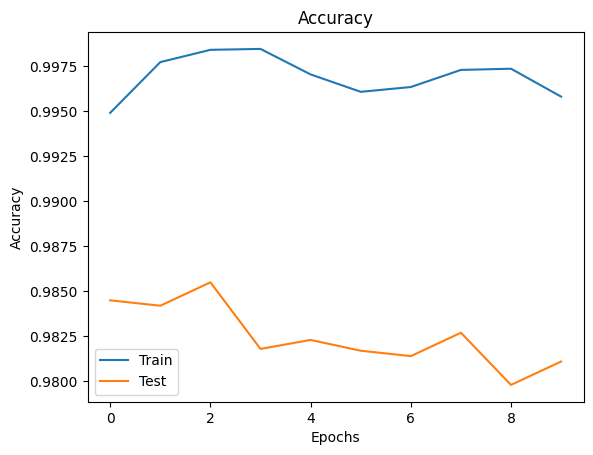

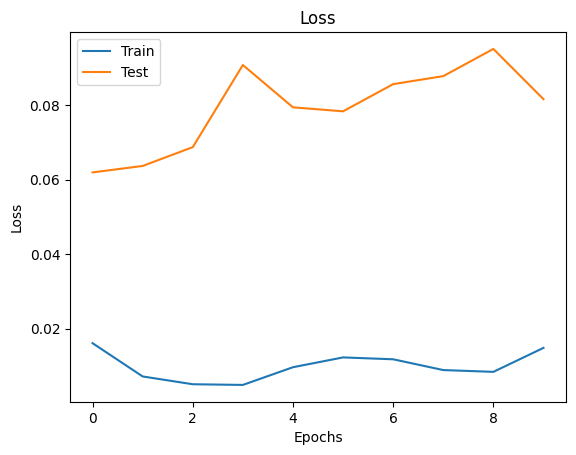

313/313 [==============================] - 1s 2ms/step
Predicted labels: [7 2 1 0 4]
True labels: [7 2 1 0 4]


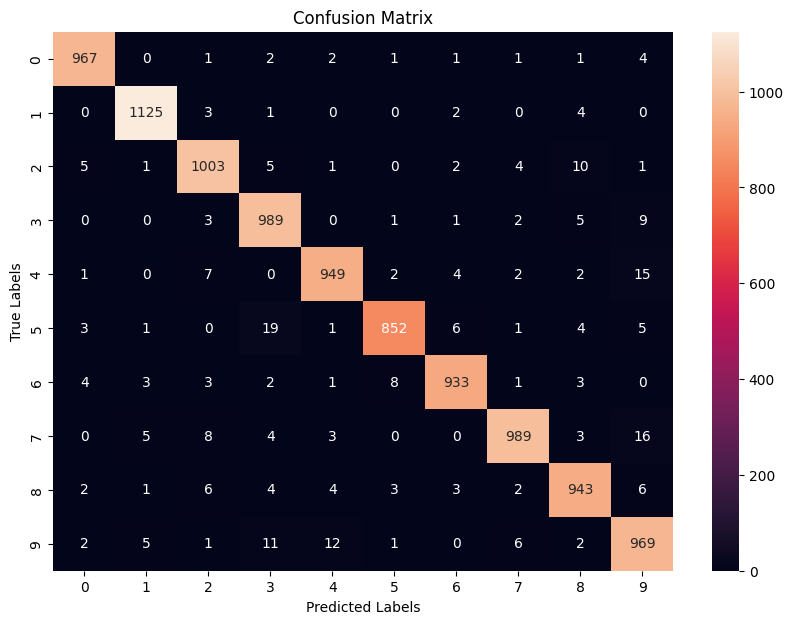

In [25]:
# # Define the model
# model = Sequential([
#     Flatten(input_shape=(28, 28)),
#     Dense(64, activation='relu', name='dense-64-relu'),
#     Dense(10, activation='softmax', name='dense-10-softmax')
# ])

# # Print model summary
# model.summary()

# # Compile the model
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define batch size and epochs
batch_size = 128
epochs = 10

# Fit the model
# history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))
history = best_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test loss: {test_loss}; Test accuracy: {test_accuracy}')

# Evaluate the model on the training data
train_loss, train_accuracy = model.evaluate(x_train, y_train)
print(f'Training loss: {train_loss}; Training accuracy: {train_accuracy}')

# Call the function to plot accuracy
plot_metric(history, 'accuracy')

# Call the function to plot loss
plot_metric(history, 'loss')

# Predict on test data
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

# Display a few predicted labels
print("Predicted labels:", y_pred[:5])
print("True labels:", y_test[:5])



plot_confusion_matrix(y_test, y_pred)



In [26]:
# Save the model
model.save("HyperParam_tune_ANN_Handwritten_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [41]:
top_3_models = tuner.get_best_models(num_models=3)

In [42]:
top_3_trials = tuner.oracle.get_best_trials(num_trials=3)  # Get the top 3 best trials


In [44]:
# best model
print('Best model:')
print('validation_accuracy:' + str(top_3_trials[0].score) )
top_3_models[0].summary()

Best model:
validation_accuracy:0.9780499935150146
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 384)               301440    
                                                                 
 dense_1 (Dense)             (None, 480)               184800    
                                                                 
 dense_2 (Dense)             (None, 448)               215488    
                                                                 
 dense_3 (Dense)             (None, 10)                4490      
                                                                 
Total params: 706218 (2.69 MB)
Trainable params: 706218 (2.69 MB)
Non-trainable params: 0 (0.00 Byte)
___________________________________

In [45]:
# second best model
print('Second Best model:')
print('validation_accuracy:' + str(top_3_trials[1].score) )
top_3_models[1].summary()

Second Best model:
validation_accuracy:0.9772000014781952
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 416)               326560    
                                                                 
 dense_1 (Dense)             (None, 10)                4170      
                                                                 
Total params: 330730 (1.26 MB)
Trainable params: 330730 (1.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
